# Librerie e Serie dati

In [1]:
%load_ext autoreload
%autoreload 2

#import warnings
#warnings.filterwarnings("ignore")
import math
from time import time
import sys
import os

import matplotlib
from matplotlib import style
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import yfinance as yf
import datetime as dt
#import seaborn as sns
import pandas as pd
import numpy as np

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 1000

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score

from nsp.nsp_utils import find_result, find_gap, find_hldif, find_emad, find_stoch, find_volat, segnale_base
from nsp.serie import Serie
from nsp.load_timeseries_data import load_data

import multiprocessing
import ray

2021-03-15 23:06:54,105	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


### Serie trigonometrica di prova

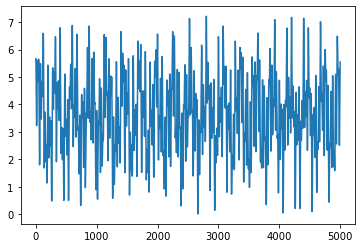

In [402]:
T = 5000
x = np.arange(0,T)
y=  np.sin(4.3*np.pi*x/200)+np.cos(8*np.pi*x/100)+np.cos(2.5*np.pi*x/50)+np.sin(0.9*np.pi*x/123)
y = y + abs(min(y)) + 0.01
plt.plot(x, y)

### Serie giornaliera

In [2]:
bitcoin_storico1 = '../bitcoin/Binance_BTCUSDT_d.csv'
df_bitcoin = pd.read_csv(bitcoin_storico1, skiprows=1)
df_bitcoin['Date'] = pd.to_datetime(df_bitcoin['Date'])
df_bitcoin.sort_values('Date', inplace=True)

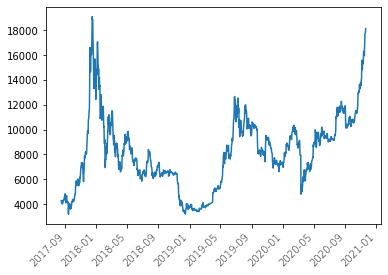

In [3]:
plt.plot(df_bitcoin['Date'], df_bitcoin['Close'])
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
);

In [ ]:
sinusoide = Serie(x,y)

In [7]:
bitcoin = Serie(df_bitcoin['Date'].values,  df_bitcoin['Close'].values, 'Close')

## Serie da Binance

In [2]:
file = '../bitcoin/BTCUSDT-1m-data.csv'
df_1min = load_data(file)
df_1min.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1832408 entries, 2017-08-17 04:00:00 to 2021-02-14 22:14:00
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Open         float64
 1   High         float64
 2   Low          float64
 3   Close        float64
 4   Volume       float64
 5   close_time   int64  
 6   quote_av     float64
 7   trades       int64  
 8   tb_base_av   float64
 9   tb_quote_av  float64
 10  ignore       float64
dtypes: float64(9), int64(2)
memory usage: 167.8 MB


### Indicatori aggiuntivi

In [4]:
# Period of Fast EMA
fast_emad = 8 # min:1, max:16
# Period of Slow EMA
slow_emad = 18 # min:1, max:32
# K period for the stochastic oscillator
k_stoch = 5 # min:1, max:16
# Smoothing Period for Stochastic Oscillator
smooth_stoch = 3 # min:1, max:8
# Volatility Calculation Period
period_volat = 6 # min:1, max:16
# Autocorrelation period
window_autocorr = 30 # min:10, max:90
# Autocorrelation lag
lag_autocorr = 4 # min:1, max:10

In [14]:
# sinusoide.aggiungi_indicatori(window_autocorr, lag_autocorr, fast_emad, slow_emad, period_volat, k_stoch, smooth_stoch)

In [15]:
# bitcoin.aggiungi_indicatori(window_autocorr, lag_autocorr, fast_emad, slow_emad, period_volat, k_stoch, smooth_stoch)
# bitcoin.new_data

,Date,AUTCOR,Close,EMAD,VOLAT
0,2017-09-16,0.625651,0.031668,0.0,0.0
1,2017-09-17,0.629224,0.030726,0.0,0.0
2,2017-09-18,0.460450,0.051809,0.0,0.0
3,2017-09-19,0.440944,0.043945,0.0,0.0
4,2017-09-20,0.440500,0.043313,0.0,0.0
...,...,...,...,...,...
1145,2020-11-16,0.402265,0.849657,0.0,0.0
1146,2020-11-17,0.391202,0.909176,0.0,0.0
1147,2020-11-18,0.402551,0.916522,0.0,0.0
1148,2020-11-19,0.410291,0.918202,0.0,0.0


In [3]:
df_1min = df_1min[['Close', 'Volume']]
btc_1min = Serie(df_1min, 'Close')
btc_1min.new_data

,Close,Volume
Date,,
2017-08-17 04:00:00,4261.48,1.775183
2017-08-17 04:01:00,4261.48,0.000000
2017-08-17 04:02:00,4280.56,0.261074
2017-08-17 04:03:00,4261.48,0.012008
2017-08-17 04:04:00,4261.48,0.140796
...,...,...
2021-02-14 22:10:00,48860.00,11.480722
2021-02-14 22:11:00,48867.67,31.361709
2021-02-14 22:12:00,48891.64,23.709751


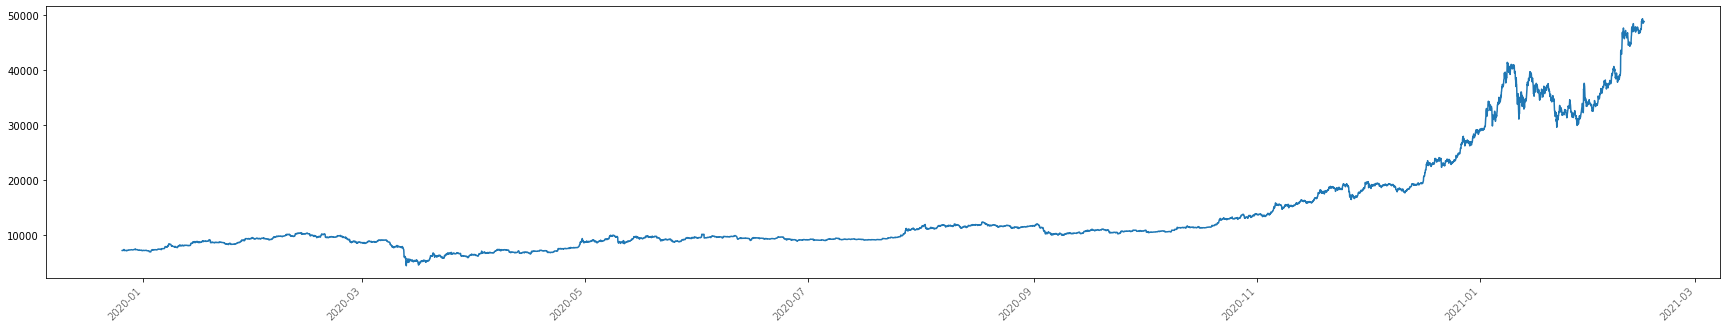

In [8]:
def plot_serie(serie, x, y):
    plt.figure(figsize=(30,5))
    plt.plot(serie[x], serie[y] )
    plt.xticks(
        rotation=45,
        horizontalalignment='right',
        fontweight='light',
        fontsize='medium',
    );
    
#plot_serie(bitcoin.new_data, 'Date', bitcoin.NOME_VALORE)
plot_serie(btc_1min.df.resample('60min').agg({'Close': 'mean', 'Volume': 'sum'}).tail(10000).reset_index(), 'Date', btc_1min.NOME_VALORE)

# Preparazione del training set

In [4]:
WINDOW = 60   #da 10 a 90... 
PERCENT = 0.8   #train data
STEP = 1 
FORECAST = 5

In [ ]:
# TODO: provare a splittare prima e poi fare il processing dei dati,
# così sui dati di test tengo i dati non normalizzati in una colonna,
#
# poi posso visualizzare la prediction sui dati originali 
# (devo fare l'inverso dello scaler sulle predictions?)

In [409]:
def from_df_to_array(df_X):
    return np.array([x.values for x in df_X])
def all_from_df_to_array(dfX_train, dfX_test, dfY_train, dfY_test):
    X_train = from_df_to_array(dfX_train)
    X_test = from_df_to_array(dfX_test)
    Y_train = from_df_to_array(dfY_train)
    Y_test = from_df_to_array(dfY_test)
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = all_from_df_to_array(dfX_train, dfX_test, dfY_train, dfY_test)

### Ultimi dati btc 1 minuto

In [5]:
btc_1min.set_parameters(WINDOW, PERCENT, STEP, FORECAST)

In [6]:
%time data, label = btc_1min.crea_pezzetti_normalizzati_np(esempio=10000)

CPU times: user 1.41 s, sys: 166 ms, total: 1.57 s
Wall time: 1.41 s


In [7]:
%time X_train, X_test, Y_train, Y_test = Serie.create_Xt_Yt(data, label, PERCENT)

CPU times: user 16.7 ms, sys: 46 µs, total: 16.7 ms
Wall time: 16.3 ms


In [8]:
data.shape, label.shape

((10000, 60, 2), (10000, 5))

In [9]:
list(map(len,[X_train, X_test, Y_train, Y_test]))

[8000, 2000, 8000, 2000]

In [10]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8000, 60, 2), (2000, 60, 2), (8000, 5), (2000, 5))

### Ottimizzare con Ray in multiprocessing (tempo totale con tutti i dati in single processing circa 5 minuti

In [16]:
%time data_label = btc_1min.crea_pezzetti_window3_ray()

(pid=54091) 2021-03-06 18:25:35,060	INFO worker.py:665 -- Calling ray.init() again after it has already been called.
(pid=54104) 2021-03-06 18:25:35,131	INFO worker.py:665 -- Calling ray.init() again after it has already been called.
(pid=54103) 2021-03-06 18:25:35,228	INFO worker.py:665 -- Calling ray.init() again after it has already been called.
(pid=54105) 2021-03-06 18:25:35,274	INFO worker.py:665 -- Calling ray.init() again after it has already been called.
(pid=54093) 2021-03-06 18:25:35,375	INFO worker.py:665 -- Calling ray.init() again after it has already been called.
(pid=54098) 2021-03-06 18:25:35,464	INFO worker.py:665 -- Calling ray.init() again after it has already been called.
(pid=54101) 2021-03-06 18:25:35,504	INFO worker.py:665 -- Calling ray.init() again after it has already been called.
(pid=54100) 2021-03-06 18:25:35,531	INFO worker.py:665 -- Calling ray.init() again after it has already been called.
(pid=54102) 2021-03-06 18:25:35,618	INFO worker.py:665 -- Callin

ObjectStoreFullError: Failed to put object ffffffffffffffffffffffffffffffffffffffff01000000463b0000 in object store because it is full. Object size is 175912772 bytes.
The local object store is full of objects that are still in scope and cannot be evicted. Tip: Use the `ray memory` command to list active objects in the cluster.

In [ ]:
dl = list(data_label)

In [ ]:
dfX_train, dfX_test, dfY_train, dfY_test = Serie.create_Xt_Yt(data, label, PERCENT)